In [33]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

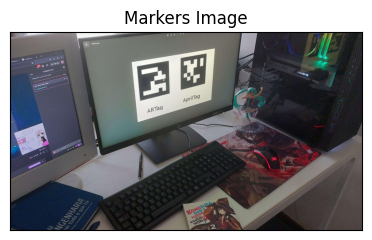

In [34]:
image = cv.imread('template-matching-images/rotate_ar.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)  # convert from BGR to RGB
plt.figure(figsize=(10,10))
plt.subplot(121),plt.imshow(image)
plt.title('Markers Image'), plt.xticks([]), plt.yticks([])
plt.show()

## Corner Detection

### Manually

In [35]:
corners = []

def corner_selector(event, x, y, flags, param):
    if event == cv.EVENT_LBUTTONDOWN:
        corners.append((x,y))
        cv.circle(image,(x,y),5,(0,255,0))
        cv.imshow('Markers Image', image)

In [36]:
MAX_CORNERS = 8

cv.imshow('Markers Image', image)

cv.setMouseCallback('Markers Image',corner_selector)

while True:
    key = cv.waitKey(1) & 0xFF
    if key == ord('q') or len(corners) == MAX_CORNERS:
        cv.destroyAllWindows()
        break

In [37]:
first_image_corners = corners[:4]

second_image_corners = corners[4:]

print("First image corners:", first_image_corners)
print("Second image corners:", second_image_corners)

First image corners: [(298, 371), (335, 310), (364, 374), (335, 441)]
Second image corners: [(261, 452), (238, 433), (236, 417), (248, 542)]


### Using OpenCV

In [38]:
def template_matching(img_object, img_scene):
    if img_object is None or img_scene is None:
        print('Could not open or find the images!')
        exit(0)
    #-- Step 1: Detect the keypoints using SURF Detector, compute the descriptors
    minHessian = 400
    detector = cv.SIFT_create()
    keypoints_obj, descriptors_obj = detector.detectAndCompute(img_object, None)
    keypoints_scene, descriptors_scene = detector.detectAndCompute(img_scene, None)
    #-- Step 2: Matching descriptor vectors with a FLANN based matcher
    # Since SURF is a floating-point descriptor NORM_L2 is used
    matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
    knn_matches = matcher.knnMatch(descriptors_obj, descriptors_scene, 2)
    #-- Filter matches using the Lowe's ratio test
    ratio_thresh = 0.75
    good_matches = []
    for m,n in knn_matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    #-- Localize the object
    obj = np.empty((len(good_matches),2), dtype=np.float32)
    scene = np.empty((len(good_matches),2), dtype=np.float32)
    for i in range(len(good_matches)):
        #-- Get the keypoints from the good matches
        obj[i,0] = keypoints_obj[good_matches[i].queryIdx].pt[0]
        obj[i,1] = keypoints_obj[good_matches[i].queryIdx].pt[1]
        scene[i,0] = keypoints_scene[good_matches[i].trainIdx].pt[0]
        scene[i,1] = keypoints_scene[good_matches[i].trainIdx].pt[1]
    H, _ =  cv.findHomography(obj, scene, cv.RANSAC)
    #-- Get the corners from the image_1 ( the object to be "detected" )
    obj_corners = np.empty((4,1,2), dtype=np.float32)
    obj_corners[0,0,0] = 0
    obj_corners[0,0,1] = 0
    obj_corners[1,0,0] = img_object.shape[1]
    obj_corners[1,0,1] = 0
    obj_corners[2,0,0] = img_object.shape[1]
    obj_corners[2,0,1] = img_object.shape[0]
    obj_corners[3,0,0] = 0
    obj_corners[3,0,1] = img_object.shape[0]
    scene_corners = cv.perspectiveTransform(obj_corners, H)
    return scene_corners

In [39]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

img_object = cv.imread('template-matching-images/template.png', cv.IMREAD_GRAYSCALE)
first_image_corners = template_matching(img_object, cv.cvtColor(image, cv.COLOR_RGB2GRAY))

img_object2 = cv.imread('template-matching-images/template2.png', cv.IMREAD_GRAYSCALE)
second_image_corners = template_matching(img_object2, cv.cvtColor(image, cv.COLOR_RGB2GRAY))

In [40]:
first_image_corners, second_image_corners

(array([[[1641.0542 ,  435.13156]],
 
        [[2103.193  ,  357.07507]],
 
        [[2118.2842 ,  847.44885]],
 
        [[1685.2177 ,  956.72437]]], dtype=float32),
 array([[[2213.834  ,  316.33682]],
 
        [[2590.3232 ,  263.97232]],
 
        [[2565.345  ,  712.03644]],
 
        [[2208.5486 ,  820.7357 ]]], dtype=float32))

## Homography

### Calculate homography matrix

In [41]:
src_points = np.array(first_image_corners, dtype=np.float32)
dst_points = np.array([(0,0),(100,0),(100,100),(0,100)],dtype=np.float32)

first_homography , _ = cv.findHomography(src_points, dst_points)

src_points = np.array(second_image_corners, dtype=np.float32)

second_homography , _ = cv.findHomography(src_points,dst_points)

### Transform the markers to a frontal veiw

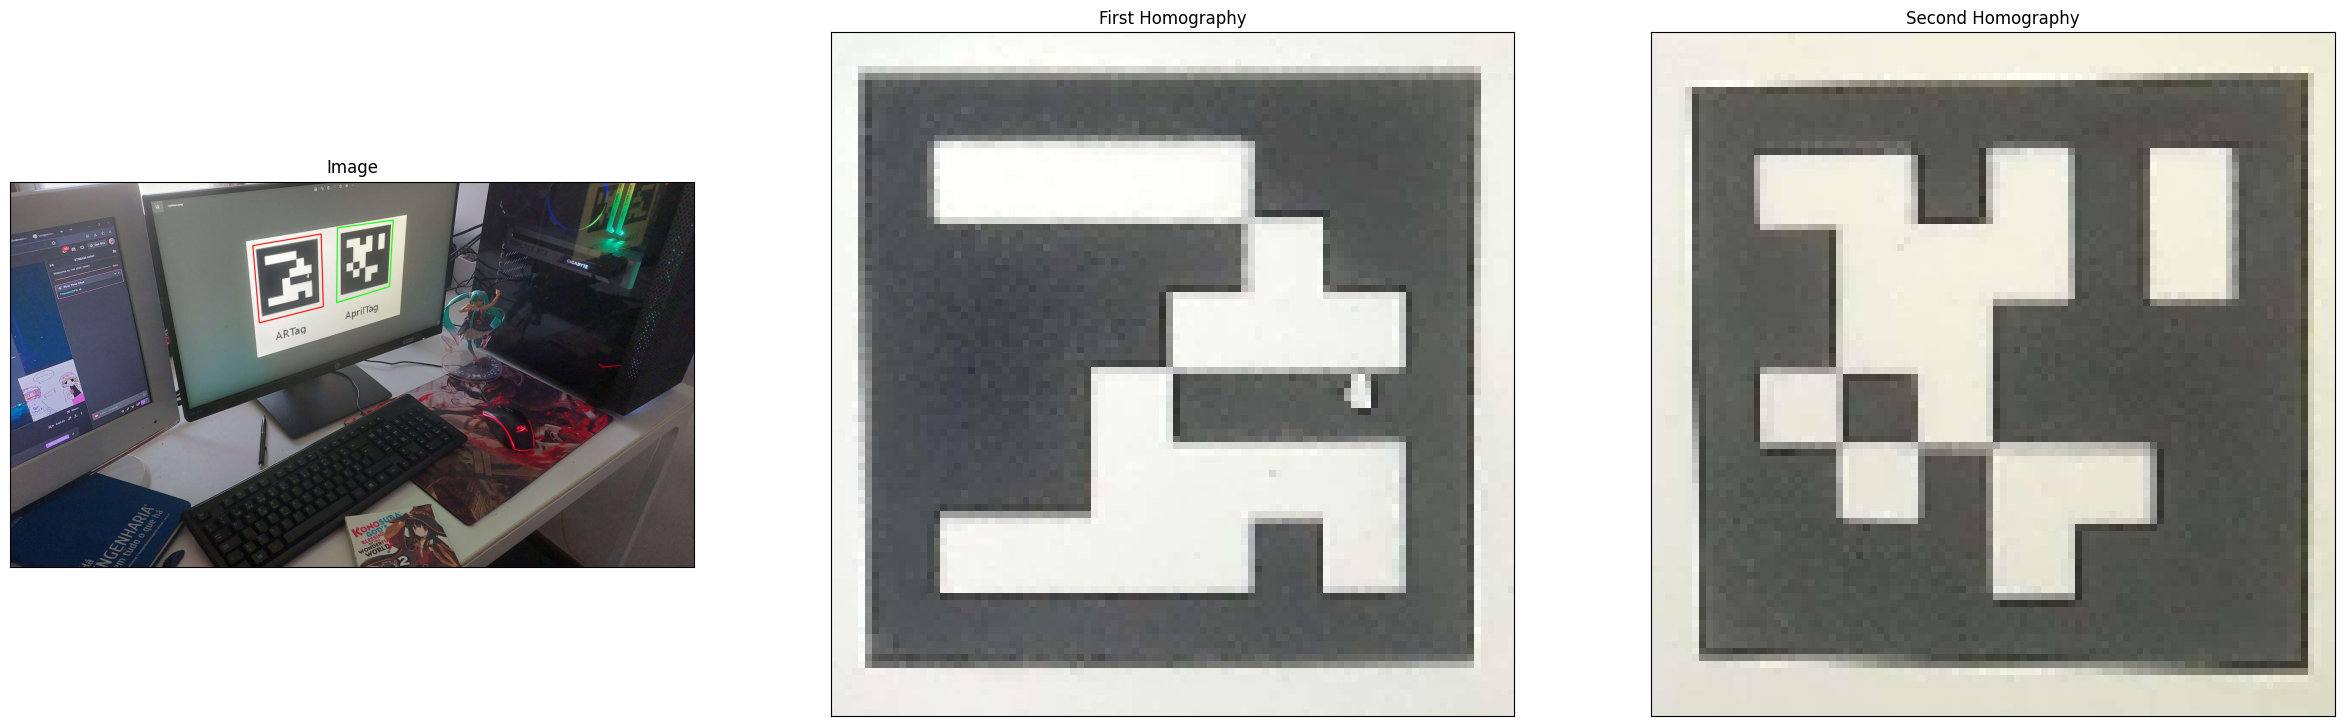

In [42]:
first_warp = cv.warpPerspective(image,first_homography,(100,100))

second_warp = cv.warpPerspective(image, second_homography,(100,100))

thickness = 5
line_type = cv.LINE_AA



cv.polylines(image,[np.int32(first_image_corners)], True, (255,0,0),thickness,line_type)
cv.polylines(image,[np.int32(second_image_corners)],True,(0,255,0),thickness, line_type)




plt.figure(figsize=(30,30))
plt.subplot(131),plt.imshow(image)
plt.title('Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(first_warp, cmap = 'gray')
plt.title('First Homography'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(second_warp, cmap = 'gray')
plt.title('Second Homography'), plt.xticks([]), plt.yticks([])
plt.show()